In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from estios.calc import regional_io_projection
from estios.models import InterRegionInputOutput
from estios.uk.scenarios import baseline_england_annual_projection,THREE_UK_CITY_REGIONS
from estios.uk.scenarios import baseline_england_annual_population_projection_config
from estios.uk.ons_population_projections import ONS_ENGLAND_POPULATION_META_DATA,ONSPopulationProjection
from copy import deepcopy
from estios.uk.utils import PUASManager, generate_uk_puas,generate_base_regions
from estios.utils import CITY_COLUMN, OTHER_CITY_COLUMN, generate_i_m_index, generate_ij_index,generate_ij_m_index
from estios.uk.regions import UK_CITY_REGIONS, UK_EPSG_GEO_CODE
from estios.spatial import sum_for_regions_by_attr
from numpy import exp
from typing import Final, Optional,Iterable
from pandas import DataFrame,Series

/opt/homebrew/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/nh/shb6sl_d0p7fsn31td_ttpzc0000gr/T/ipykernel_72929/4146745137.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.rea

In [2]:
region=[
 'Barnsley',
 'Bristol',
 'Basildon',
 'Birmingham',
 'Blackpool',
 'Bradford',
 'Burnley',
 'Cambridge',
 'Chatham',
 'Coventry',
 'Crawley',
 'Derby',
 'Doncaster',
 'Exeter',
 'Gloucester',
 'Huddersfield',
 'Ipswich',
 'Leeds',
 'Leicester',
 'Liverpool',
 'London',
 'Luton',
 'Manchester',
 'Mansfield',
 'Middlesbrough',
 'Milton Keynes',
 'Norwich',
 'Nottingham',
 'Oxford',
 'Peterborough',
 'Plymouth',
 'Portsmouth',
 'Newcastle',
 'Preston',
 'Reading',
 'Sheffield',
 'Slough',
 'Southampton',
 'Sunderland',
 'Swindon',
 'Telford',
 'Wakefield',
 'Warrington',
 'Wigan',
 'Worthing',
 'York',
 'Hull',
]
annuals=baseline_england_annual_projection(regions=region, years=[2022,2027,2032,2037,2042])
IO=deepcopy(annuals[0])

No ONS data directly available on Aldershot
Adding no uk_contemporary flag to {'pua': 'Aldershot', 'no uk_contemporary': True}
No ONS data directly available on Birkenhead
Adding no uk_contemporary flag to {'pua': 'Birkenhead', 'no uk_contemporary': True}
No ONS data directly available on Blackburn
Adding no uk_contemporary flag to {'pua': 'Blackburn', 'no uk_contemporary': True}
No ONS data directly available on Bournemouth
Adding no uk_contemporary flag to {'pua': 'Bournemouth', 'no uk_contemporary': True}
No ONS data directly available on Bournemouth Christchurch and Poole
Adding no uk_contemporary flag to {'pua': 'Bournemouth, Christchurch and Poole', 'no uk_contemporary': True, 'code': 'E06000058', 'year changed': 2019}
Adding year changed flag to {'pua': 'Bournemouth, Christchurch and Poole', 'no uk_contemporary': True, 'code': 'E06000058', 'year changed': 2019}
No ONS data directly available on Brighton
Adding no uk_contemporary flag to {'pua': 'Brighton', 'no uk_contemporary': 

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_indicator(indicator_list,geolist,indicator_name,year,save=False):
    geolist_IO=geolist[geolist["NAME1"].isin(list(indicator_list.index))]
    geolist_new=geolist_IO.join(indicator_list,on="NAME1")
    fig,ax = plt.subplots(figsize=(20,30)) 
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.title("City-level "+ str(indicator_name) +" in " + str(year))
    geolist_new.plot(ax=ax,column=indicator_name, legend=True, cax=cax,markersize=((geolist_new[indicator_name]-19.5)*900),cmap='BuPu',alpha=0.7)
    boundary[boundary["CTRY22NM"]=='England'].boundary.plot(color="black",alpha=0.3,linestyle="-.",ax=ax)
    geolist_new.apply(lambda x: ax.annotate(text=x['NAME1'], xy=x.geometry.coords[0], ha='center',size=(x[indicator_name]-18)*3), axis=1)
    if save:
        plt.savefig("fig/"+str(indicator_name)+str(year)+'.jpg')


In [4]:
import numpy as np
GDP_list=DataFrame(index=annuals.regions)
GDP_pp_list=DataFrame(index=annuals.regions)
rank_df=DataFrame(columns=list(annuals.years),index=annuals.regions)
for i in range (len(annuals)):
    year=annuals[i].year
    GDP=annuals[i].GDP.sum(axis=1)
    GDP_percapita=GDP/annuals[i].regional_populations
    GDP_list[year]=GDP
    GDP_pp_list[year]=GDP_percapita
    rank_df[year]=GDP.rank(ascending=False)


Potential inefficient indexing years method, consider generator


In [5]:
GDP_pp_list=GDP_pp_list*(2.683/1.844)

In [6]:
GDP_list['Increase Rate 17-27']=(GDP_list[2027]-GDP_list[2017])/GDP_list[2017]*100
GDP_list['Increase Rate 17-42']=(GDP_list[2042]-GDP_list[2017])/GDP_list[2017]*100

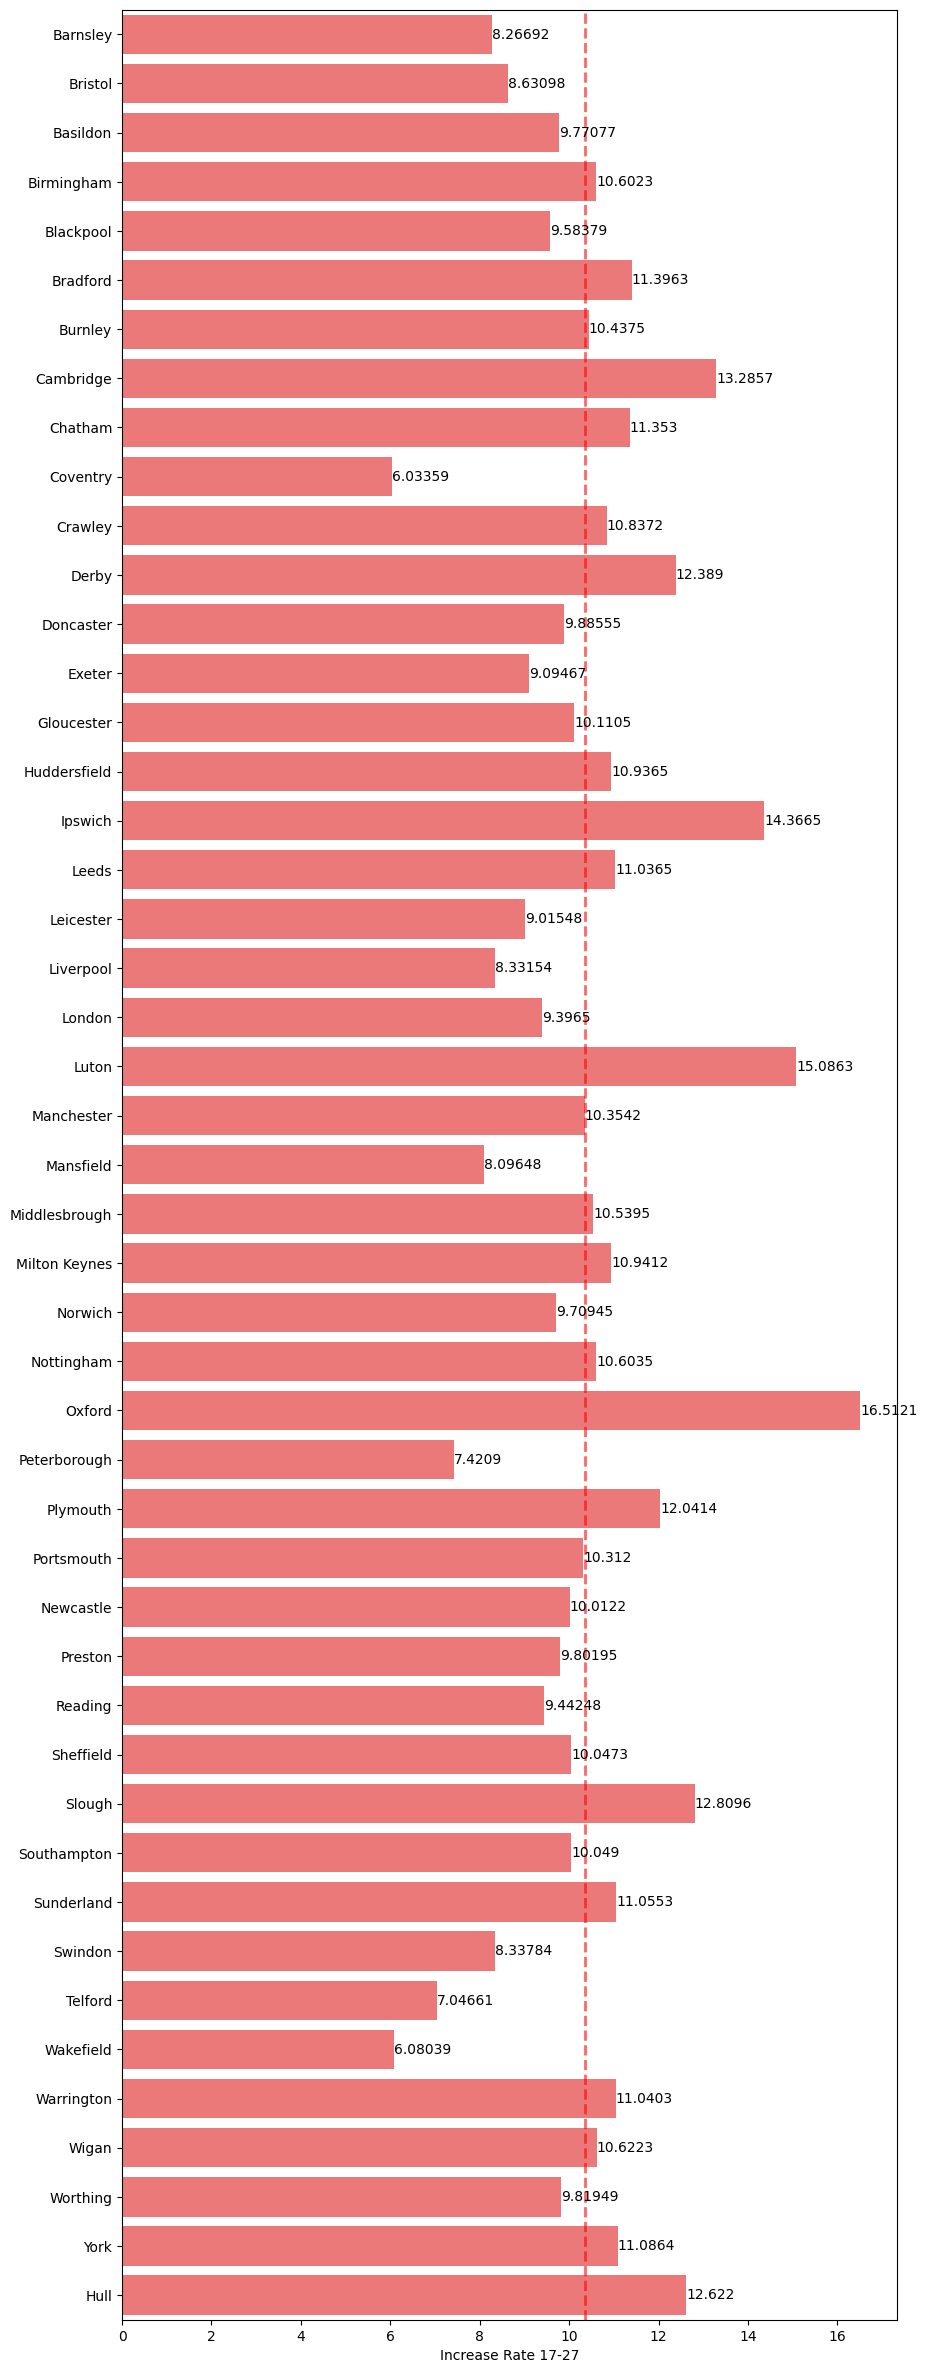

In [7]:
import seaborn as sns
GDP_pp_list['Increase Rate 17-27']=(GDP_pp_list[2027]-GDP_pp_list[2017])/GDP_pp_list[2017]*100
GDP_pp_list['Increase Rate 17-42']=(GDP_pp_list[2042]-GDP_pp_list[2017])/GDP_pp_list[2017]*100

plt.figure(figsize=(10, 30))
gfg=sns.barplot(x="Increase Rate 17-27", y=GDP_pp_list.index, data=GDP_pp_list,color="r",alpha = 0.6)
gfg.bar_label(gfg.containers[0])
plt.axvline(x=np.mean(GDP_pp_list['Increase Rate 17-27']), c = 'r', ls = '--', lw = 2, alpha = 0.6)
plt.savefig('fig/Increase Rate 17-27.png')

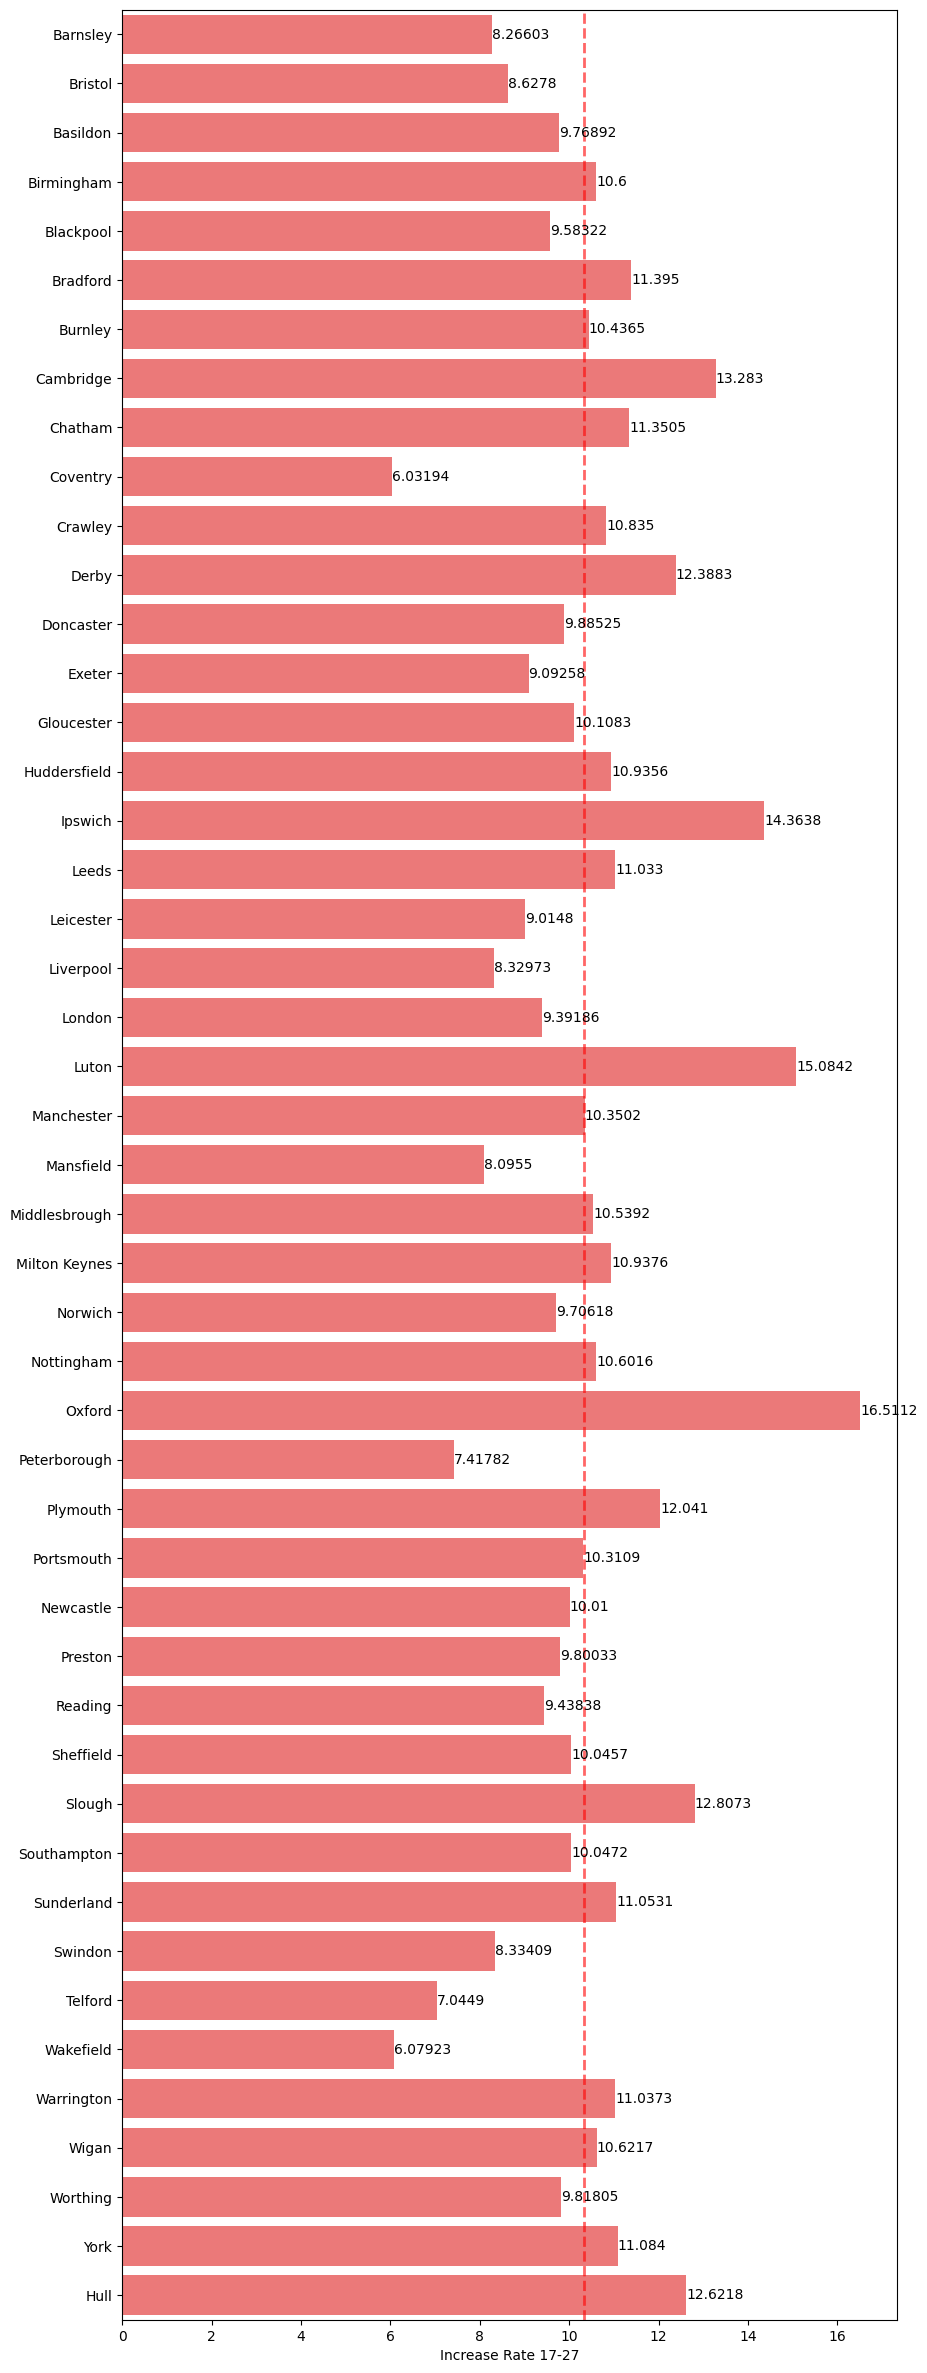

In [21]:
import seaborn as sns
GDP_pp_list['Increase Rate 17-27']=(GDP_pp_list[2027]-GDP_pp_list[2017])/GDP_pp_list[2017]*100
GDP_pp_list['Increase Rate 17-42']=(GDP_pp_list[2042]-GDP_pp_list[2017])/GDP_pp_list[2017]*100

plt.figure(figsize=(10, 30))
gfg=sns.barplot(x="Increase Rate 17-27", y=GDP_pp_list.index, data=GDP_pp_list,color="r",alpha = 0.6)
gfg.bar_label(gfg.containers[0])
plt.axvline(x=np.mean(GDP_pp_list['Increase Rate 17-27']), c = 'r', ls = '--', lw = 2, alpha = 0.6)
plt.savefig('fig/Increase Rate 17-27.png')

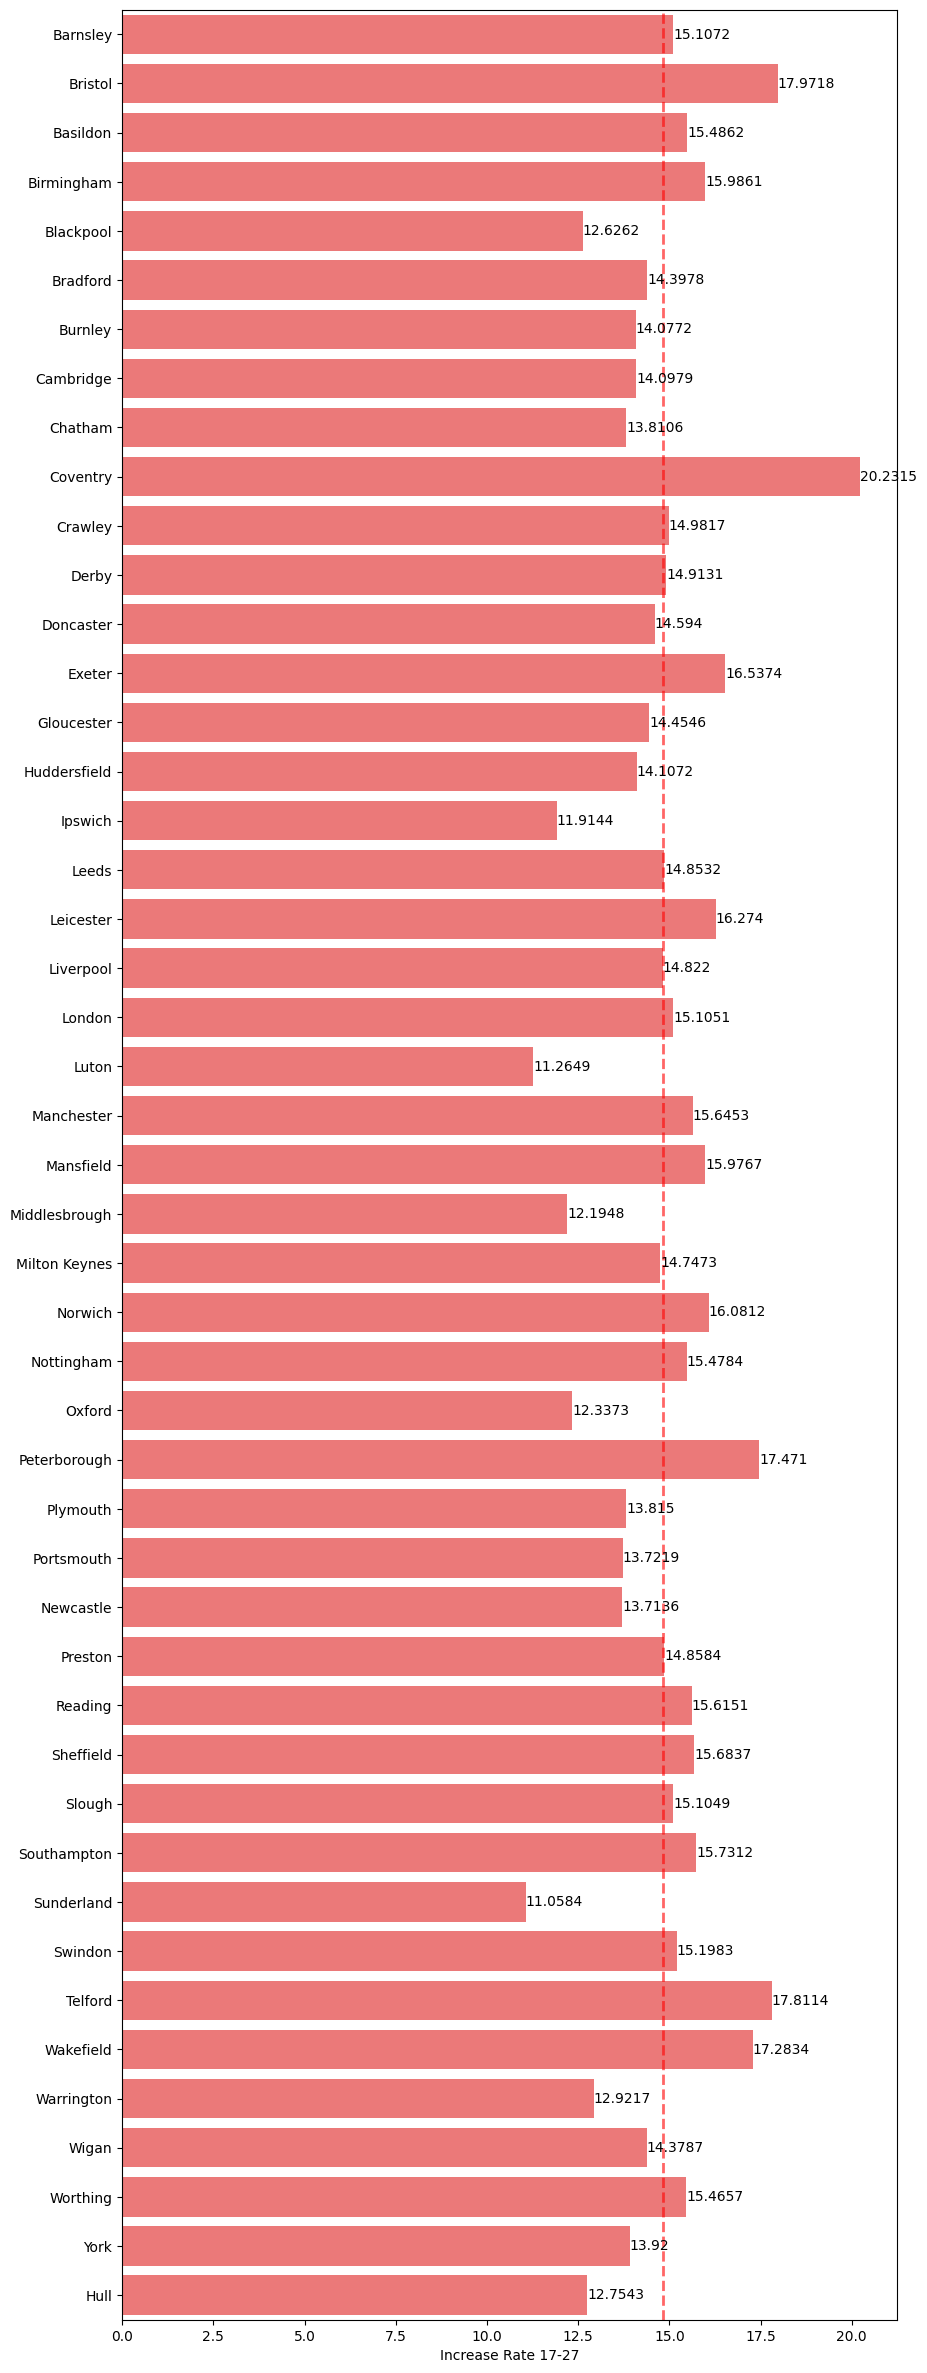

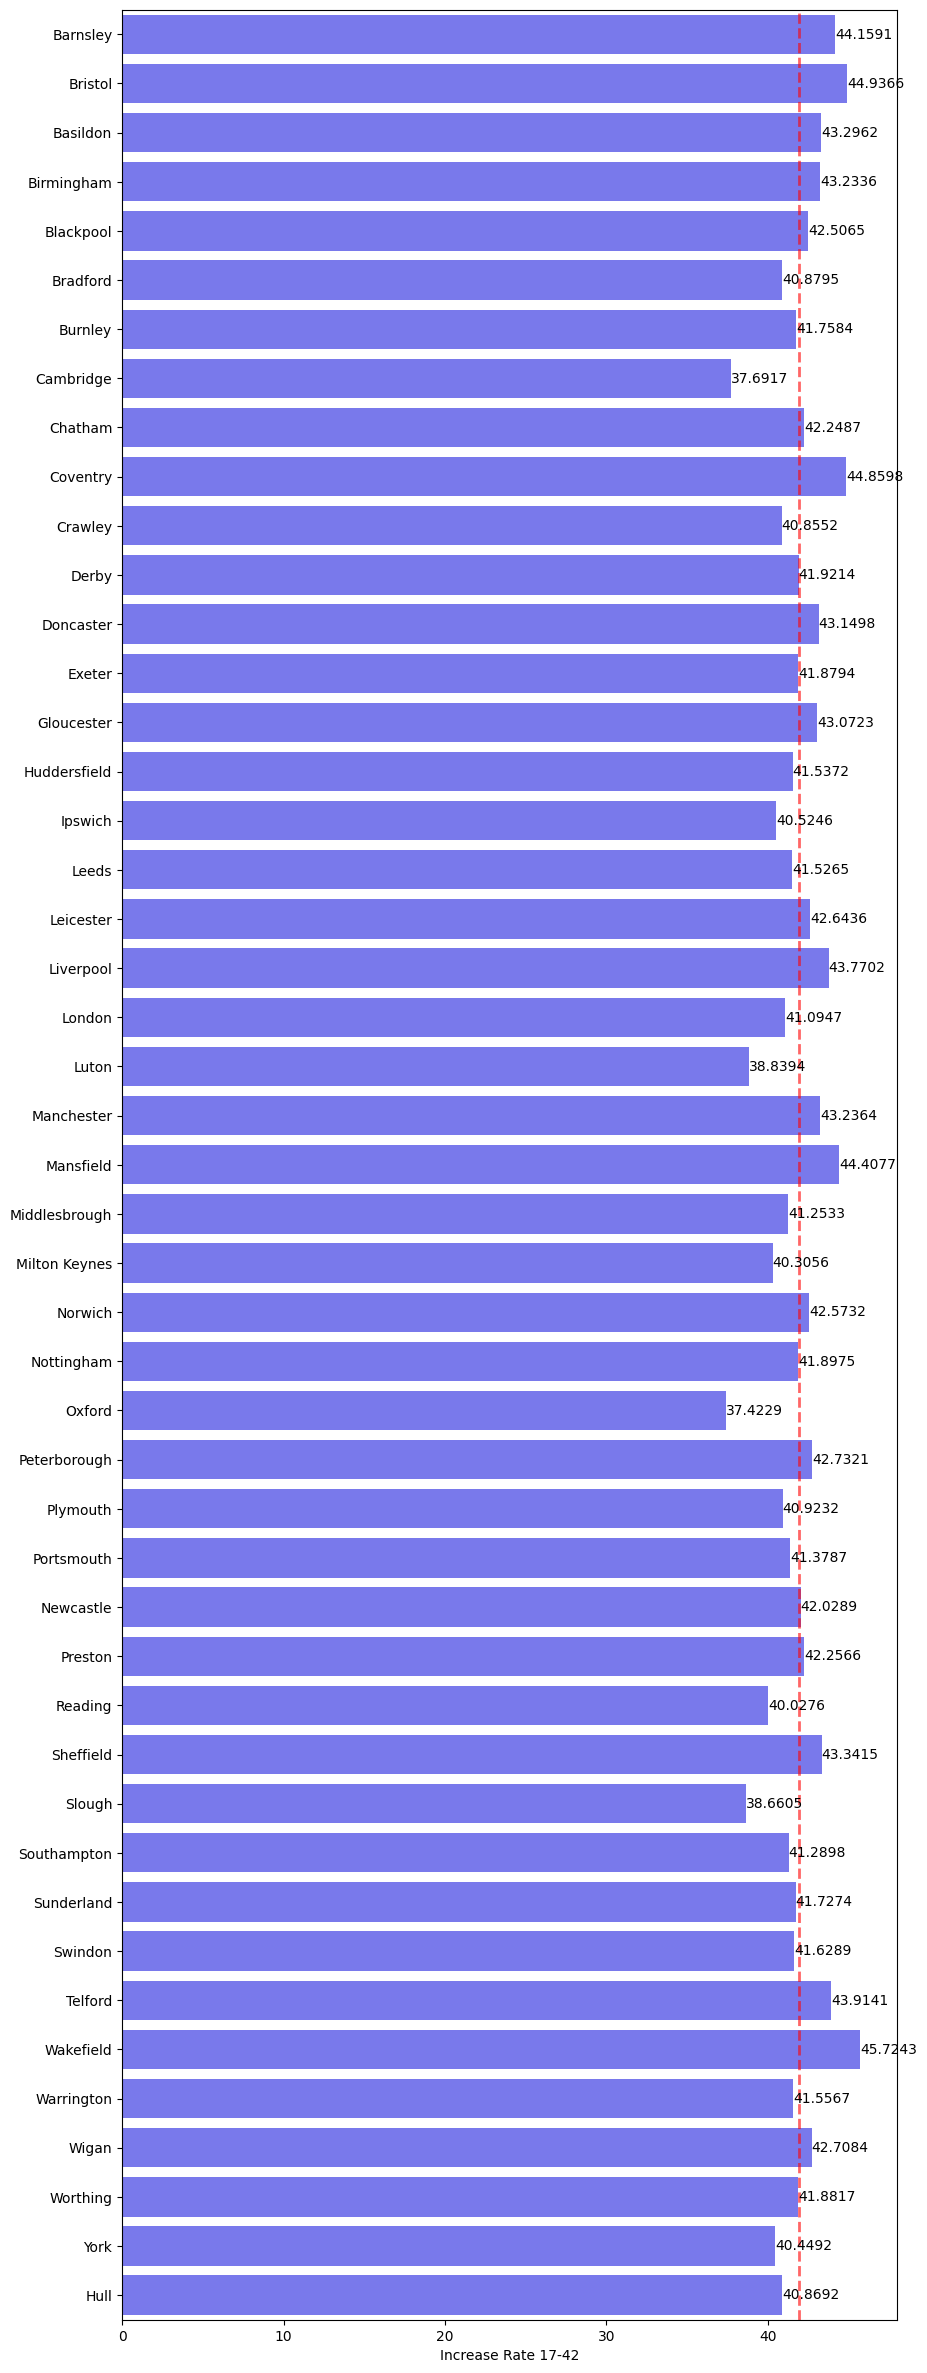

In [26]:
plt.figure(figsize=(10, 30))
gfg=sns.barplot(x="Increase Rate 17-27", y=GDP_list.index, data=GDP_list,color="r",alpha = 0.6)
gfg.bar_label(gfg.containers[0])
plt.axvline(x=np.mean(GDP_list['Increase Rate 17-27']), c = 'r', ls = '--', lw = 2, alpha = 0.6)
plt.savefig('fig/Increase Rate 2017-2027.png')

plt.figure(figsize=(10, 30))
gfg=sns.barplot(x="Increase Rate 17-42", y=GDP_list.index, data=GDP_list,color="b",alpha = 0.6)
gfg.bar_label(gfg.containers[0])
plt.axvline(x=np.mean(GDP_list['Increase Rate 17-42']), c = 'r', ls = '--', lw = 2, alpha = 0.6)
plt.savefig('fig/Increase Rate 2017-2042.png')

In [8]:
IO.io_table.iloc[:,10:-1].dropna().sum().sum()-IO.io_table[IO.io_table.index=='Imports'].sum().sum()

1613450251479.4639

In [9]:
IO.io_table

,Agriculture,Production,Construction,"Distribution, transport, hotels and restaurants",Information and communication,Financial and insurance,Real estate,Professional and support activities,"Government, health & education",Other services,Household Purchase,Government Purchase,Non-profit Purchase,Exports to EU,Exports outside EU,Exports of services,Total Purchase
Agriculture,3615648621.331148,12433010641.357439,76771231.539453,782210020.91892,14542889.961135,15292.024176,176770131.513069,118830500.17583,51946474.820382,35302420.2531,7062668718.638894,1994.177565,997.088783,1763926085.612784,684830601.813795,188592343.689565,28188000000.000011
Production,5727624905.989972,168797486224.777496,40041372155.248131,59031877827.838409,8126719817.671847,4742751506.946955,5241869587.037829,17558197600.832325,34727237420.009071,5346303713.943548,105558431746.339447,10293857909.388012,1000.0,90707759078.791092,86241426906.302612,11151671845.736397,676770005000.000122
Construction,283194654.340715,5973047491.588834,90642843229.258896,5986822979.027637,212543783.075449,3721262459.271041,20238674426.80685,3230286539.257743,6199957777.642778,214943112.90552,1594970999.99997,1999.999985,999.999992,999.999992,999.999992,2448966992.419703,303108995999.999939
"Distribution, transport, hotels and restaurants",3301759294.793789,66155990157.493652,14337848416.387022,92155766896.208374,8382373292.959646,16662463856.599552,3295653969.651456,25326878501.907269,26324795904.32053,3688939709.678714,268557350000.000092,3086008000.0,4000.0,28804005000.0,27199005000.0,43612149000.000008,643465995000.0
Information and communication,316057476.775523,6355387049.475625,2726328429.412366,12022535333.556639,19047233141.74818,17753420941.571747,3187719624.257404,12657088553.13332,9071112799.195587,2685569998.347643,31863533999.999992,3312002000.0,1000.0,1335000000.0,1244000000.0,34815001474.625565,197855001000.0
Financial and insurance,1236049359.711349,17679716297.161942,4660329419.189104,13357767041.898478,3084810502.556663,25967338018.546986,29562858422.906437,9676538869.584078,8499414849.150187,1620043219.294782,64147339000.000015,0.0,0.0,0.0,0.0,78966798000.000015,258459003000.0
Real estate,114192.820995,1752441549.619571,370527750.728178,18411366556.149811,3565064801.112846,3869695866.665901,2555013269.629437,5961082515.724539,7926977063.713786,1267937433.834934,288737769000.0,2000.0,1287001000.0,1000.0,1000.0,1706002000.0,346088998000.0
Professional and support activities,1515340447.803658,26395736062.438213,14256680800.55109,49608974427.686073,20973243438.3102,29496231744.263454,10402992366.572868,81337151278.319443,30295522332.217464,8436245101.83755,32234707000.000027,2000.0,2520002000.0,25001000.0,19001000.0,96094045000.0,445194987999.999939
"Government, health & education",16420981.151697,1788655806.932154,1332445801.04352,3428145462.891937,1089087173.919858,2517287573.117056,4919836036.786192,6437533940.871499,30317309288.980598,201028934.305492,57067262000.000061,360451002999.999939,36340956999.999992,2000.0,2000.0,10855019000.0,517874998000.0
Other services,23948518.534256,167916634.260883,21972191.547981,407123877.482125,1545261240.739113,1488014312.425617,127533288.94009,1048318982.92349,3935928211.835524,5039512741.310922,65118600000.000008,3988002000.0,7298001000.0,14049000.0,4337829000.0,2205991000.0,96332001000.0
